# Agent interaction analysis
## Step by step data extraction

In [36]:
# Imports
import pandas as pd
# from egg.core.interaction import Interaction
import torch
from sklearn.decomposition import PCA
from pathlib import Path
from matplotlib import pyplot as plt
from egg.zoo.pop.scripts.analysis import interaction_to_dataframe
# used in a later part of the script :
# import seaborn as sns
# import numpy as np


ModuleNotFoundError: No module named 'egg.zoo.pop.scripts.analysis'

In [3]:
# Path to your interaction file
path_to_interaction = Path("/Users/u203445/Documents/projects/EGG/")
inter = torch.load(path_to_interaction / "cont_interactions_2")

In [37]:
df_inter = interaction_to_dataframe(inter)
# quick overview of what data is available in the dataframe's columns
print(df_inter.columns)

Index(['labels', 'sender_idx', 'recv_idx', 'loss_idx', 'batch_number', 'dim_0',
       'dim_1', 'dim_2', 'dim_3', 'dim_4', 'dim_5', 'dim_6', 'dim_7', 'dim_8',
       'dim_9', 'dim_10', 'dim_11', 'dim_12', 'dim_13', 'dim_14', 'dim_15',
       'receiver_output'],
      dtype='object')


## Begining of a PCA analysis
lets make an n component PCA with the scikit-learn tool, to get a visual idea of clusters and their correspondance to the pretrained 'human' classes

In [20]:
# select which sender to analyse and which pretraining class labels
# chosen_sender_index = [0,1,2,3]
_chosen_sender_index = [2,3]
# _chosen_labels = [i for i in range(100)]
_chosen_labels = [1, 32, 80]
# taking only the interactions that have the matching indexes for the sender and the class labels
selectedsender_interactions = df_inter[df_inter.sender_idx.isin(_chosen_sender_index)]
selectedsender_interactions = df_inter[df_inter.labels.isin(_chosen_labels)]

In [49]:
# Doing the actual PCA
n_components=10
pca = PCA(n_components)
x = selectedsender_interactions.loc[:, selectedsender_interactions.columns.str.contains('dim')]
principalComponents = pca.fit_transform(x)
df_pca = pd.DataFrame(data = principalComponents
             , columns = [f'principal component {i+1}' for i in range(n_components)])

# adding the labels for colouring purposes in plot
df_pca['labels'] = selectedsender_interactions.labels.values
# so this stays readable, we only visualise the first to pc, and only three randomly selected datapoints
print(df_pca[['principal component 1','principal component 2']].sample(3))

      principal component 1  principal component 2
162               -0.492505              -0.083175
1201               0.508058               0.587465
1893               0.135601               0.335038


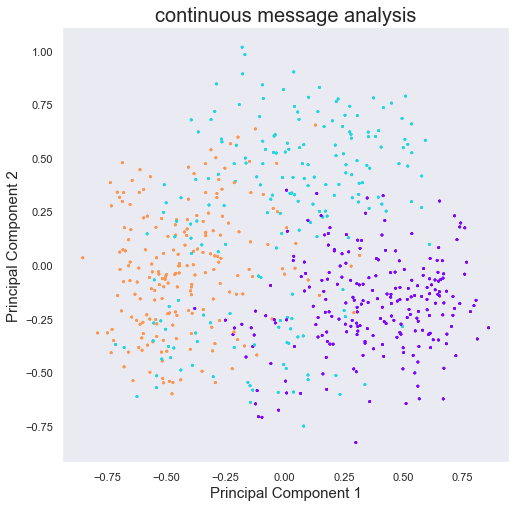

In [35]:
# plotting the PCA (looking at all the data is too)
# Chose here which components you want to look at (1 and 2 should have most information) 
prin_comp_A = 1
prin_comp_B = 2

fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel(f'Principal Component {prin_comp_A}', fontsize = 15)
ax.set_ylabel(f'Principal Component {prin_comp_B}', fontsize = 15)
ax.set_title('continuous message analysis', fontsize = 20)
colors = plt.cm.rainbow(torch.arange(0, 1, 0.01))

# here I´m colouring the different classes with different colours
ax.scatter(df_pca[f'principal component {prin_comp_A}']
            , df_pca[f'principal component {prin_comp_B}']
            , color = colors[df_pca['labels']]
            , s = 3)
ax.grid()

## Some other basic things
Looking at the message distribution for intuition of where the information is hidden

In [10]:
# New part, new imports. This facilitates some graphs
import seaborn as sns

In [50]:
# Setting each dimension column as a categorical variable (called dim) instead of a separate column.
# This facilitates creation of separate graphs per dimension which we do later
melted_df = df_inter.melt(["sender_idx","loss_idx", "recv_idx", "labels", "receiver_output", "batch_number"], var_name="dim", value_name="message_value")
# lets look at what the dataframe now looks like for three randomly selected datapoints
print(melted_df.sample(3))

         sender_idx  loss_idx  recv_idx  labels  receiver_output  \
1058060           0         0         3      39               12   
999002            2         0         0      23               26   
1260362           3         0         0      30               10   

         batch_number     dim  message_value  
1058060          4748  dim_13       0.775444  
999002            602  dim_12       0.512196  
1260362          2378  dim_15       0.219451  


<AxesSubplot:xlabel='dim', ylabel='message_value'>

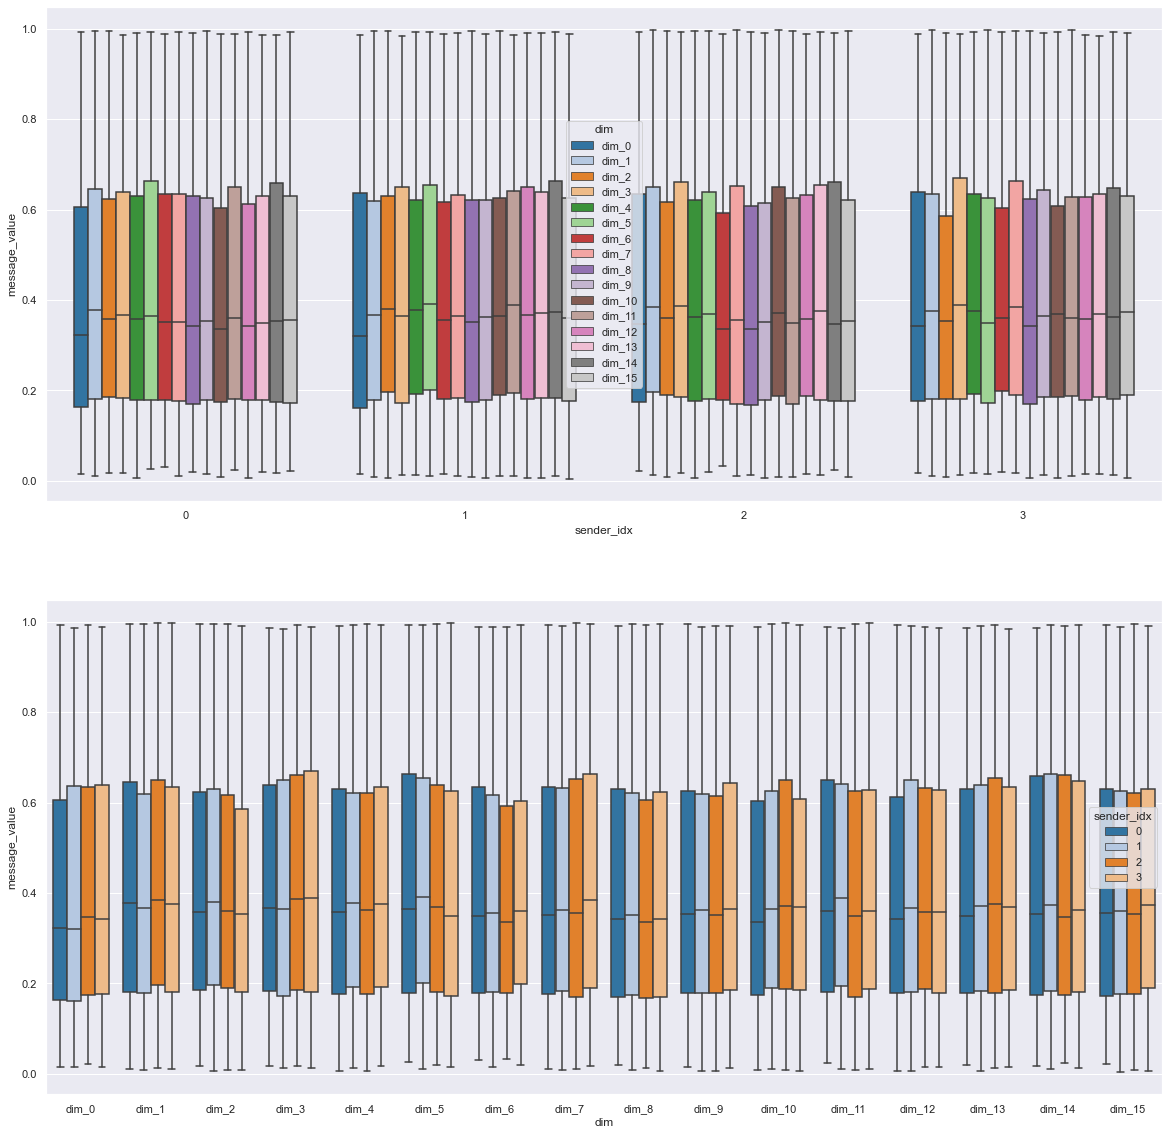

In [23]:
#lets check messages are evenly distributed accross dimensions and senders
sns.set(rc={'figure.figsize':(20,20)})
fig, axes = plt.subplots(2,1) 
sns.boxplot(x=melted_df.sender_idx, y=melted_df.message_value, hue=melted_df.dim, palette=sns.color_palette("tab20",16),ax=axes[0])
sns.boxplot(x=melted_df.dim, y=melted_df.message_value, hue=melted_df.sender_idx, palette=sns.color_palette("tab20",16),ax=axes[1])

# This does not seem to call for further statistical testing... quite similar, they've all gone through a sigmoid. Might still check to be sure.

In [62]:
# Now we will focus on a single sender. Change the index here to redo the same analysis on a different sender
sender_idxs = [0,1,2,3]

A quick look at the data distribution for messages in each dimension

<AxesSubplot:xlabel='dim', ylabel='message_value'>

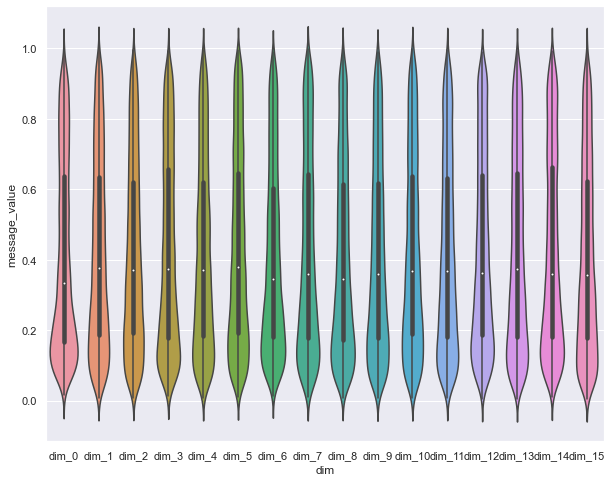

In [58]:
sns.set(rc={'figure.figsize':(10,8)})
sns.violinplot(x=melted_df[melted_df.sender_idx.isin(sender_idxs)].dim, y=melted_df[melted_df.sender_idx.isin(sender_idxs)].message_value)
# This tends to give an idea of what the saturation point is for the sigmoid... I'd set it around 0.35

Now we check if data distribution is modified by the class of the represented image (which it should if it wants to discriminate images)

C:\Users\u203445\AppData\Local\Temp\ipykernel_22744\2413283860.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  _df = melted_df[melted_df.labels==label][melted_df.sender_idx.isin(sender_idxs)]
C:\Users\u203445\AppData\Local\Temp\ipykernel_22744\2413283860.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  _df = melted_df[melted_df.labels==label][melted_df.sender_idx.isin(sender_idxs)]
C:\Users\u203445\AppData\Local\Temp\ipykernel_22744\2413283860.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  _df = melted_df[melted_df.labels==label][melted_df.sender_idx.isin(sender_idxs)]
C:\Users\u203445\AppData\Local\Temp\ipykernel_22744\2413283860.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  _df = melted_df[melted_df.labels==label][melted_df.sender_idx.isin(sender_idxs)]
C:\Users\u203445\AppData\Local\Temp\ipykernel_22744\2413283860.py:4: UserWarning: Boolea

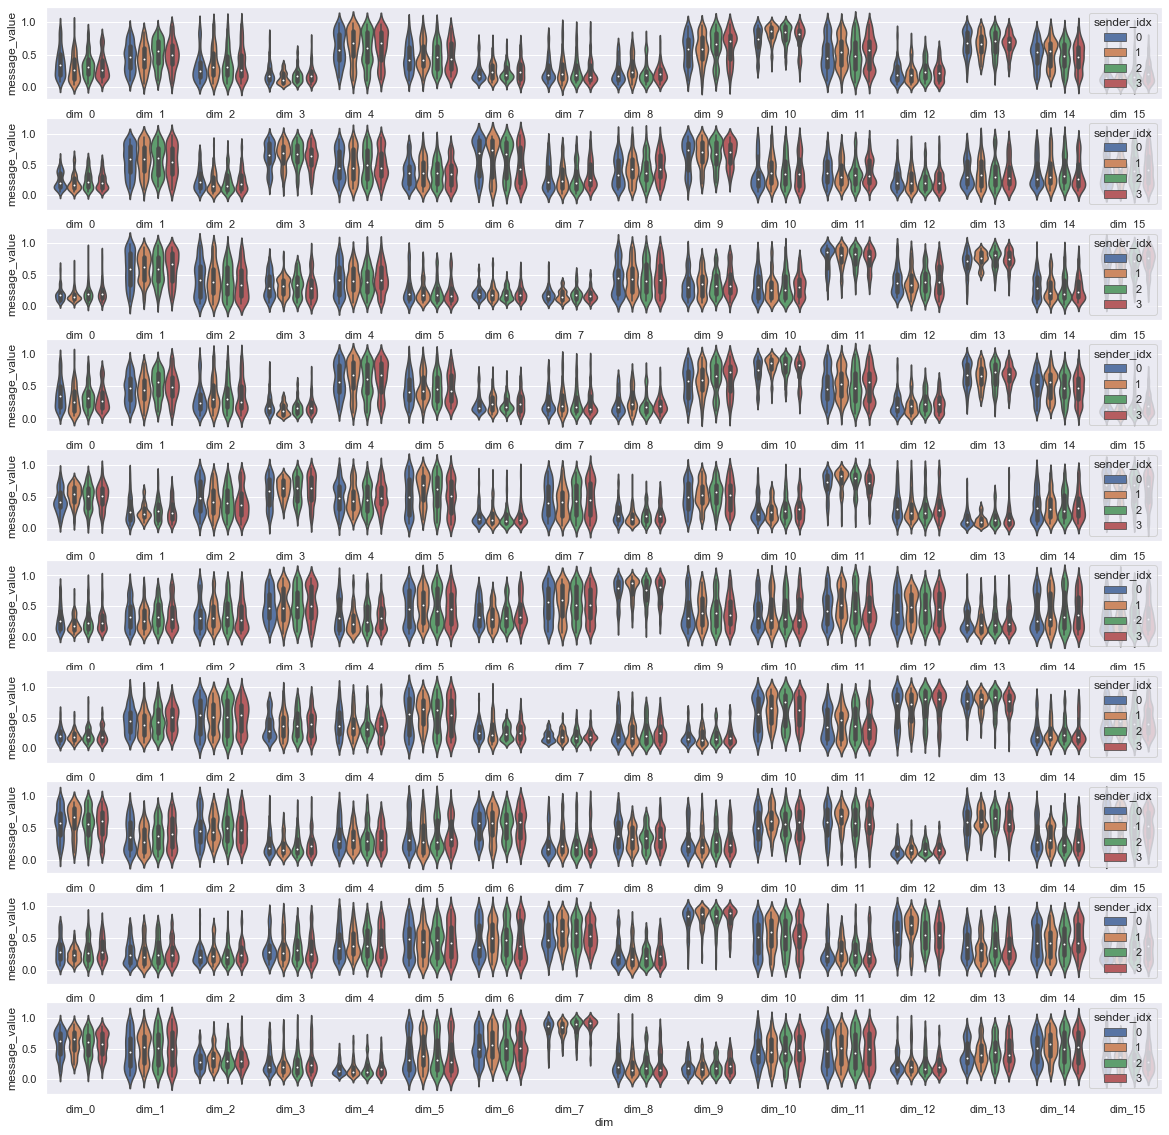

In [63]:
sns.set(rc={'figure.figsize':(20,20)})
fig, axes = plt.subplots(10,1) 
for i, label in enumerate(melted_df.labels.sample(10)):
    _df = melted_df[melted_df.labels==label][melted_df.sender_idx.isin(sender_idxs)]
    if len(_df) != 0:
        sns.violinplot(x=_df.dim, y=_df.message_value, hue=_df.sender_idx, ax=axes[i])

# We can see variations in dimensional distribution depending on the pre-training classes. Each sender seems to encode it in a similar manner ! 
# (which can be understood as either an approximation of the actual clustering, or perhaps the beginning of an analysis of model capacities in out-of-scope contexts)
# vit, the agent with the most different representation, is in orange (sender_idx = 1). We can see it is always using slightly different communication distributions

<AxesSubplot:>

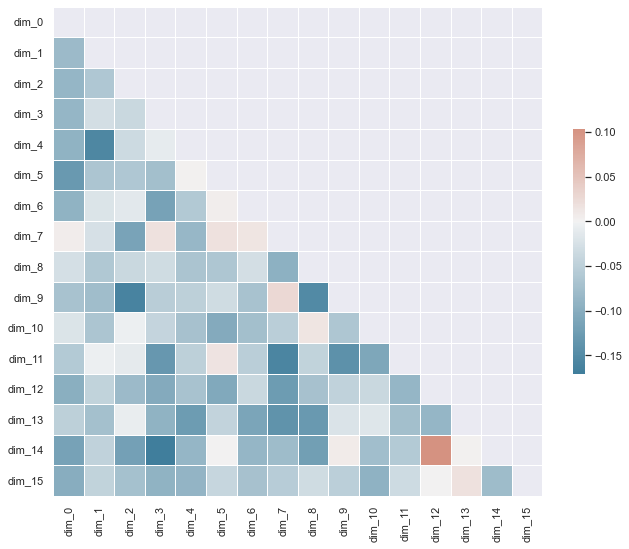

In [33]:
# Ok. Correlation between dimensions now. Are any dimensions unnecessary ?
import numpy as np
# Compute the correlation matrix
# (just on the dims, not on the rest of the information in interactions)
corr = df_inter.loc[:,df_inter.columns.str.contains('dim')].corr()
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

# looks quite independant no ? with that in mind they'd all be necessary.

lets add :
* Independance of dims test
* entropy of pop languages vs one on one languages
* 